### Short Analysis

o_image Shape: (256, 256)
o_image Data type: float64
o_image Max value: 1.0
o_image Min value: -0.33344187561055033
m_image Shape: (256, 256)
m_image Data type: float64
m_image Max value: 1.0
m_image Min value: 0.0


(-0.5, 255.5, 255.5, -0.5)

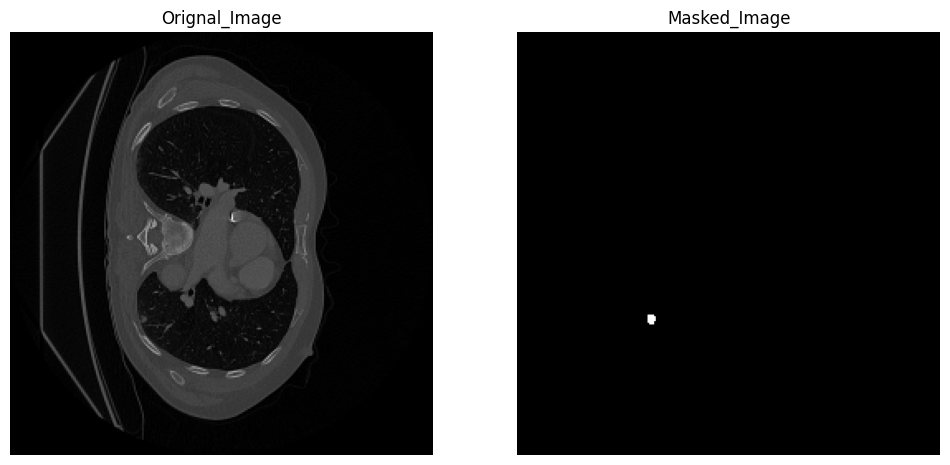

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
o_image = np.load("/kaggle/input/lung-tumor-segmentation/train/train/28/data/112.npy")
m_image = np.load("/kaggle/input/lung-tumor-segmentation/train/train/28/masks/112.npy")

# Check the shape, type, max and min value
print("o_image Shape:", o_image.shape)
print("o_image Data type:", o_image.dtype)
print(f'o_image Max value: {np.max(o_image)}')
print(f'o_image Min value: {np.min(o_image)}')

print("m_image Shape:", m_image.shape)
print("m_image Data type:", m_image.dtype)
print(f'm_image Max value: {np.max(m_image)}')
print(f'm_image Min value: {np.min(m_image)}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(o_image, cmap='gray')
plt.title('Orignal_Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(m_image, cmap='gray')
plt.title('Masked_Image')
plt.axis('off')

### Data is Already normalized

In [1]:
import os
import numpy as np

data_path = '/kaggle/input/lung-tumor-segmentation'
original_images = []
masked_images = []


for case in os.listdir(data_path):
    case_path = os.path.join(data_path, case)
    
    # Collect data and mask files
    data_files = []
    mask_files = []
    
    for root, dirs, files in os.walk(case_path):
        if root.lower().endswith("data"):
            data_files = sorted([os.path.join(root, f) for f in files])
                
        elif root.lower().endswith("masks"):
            mask_files = sorted([os.path.join(root, f) for f in files])
    
    # Process paired files
    for data_file, mask_file in zip(data_files, mask_files):
        img = np.load(data_file)
        mask = np.load(mask_file)
        
        # Check if mask has tumor (any non-zero pixels)
        if np.sum(mask > 0) > 0:
            original_images.append(img)
            masked_images.append(mask)

print(f"Images with tumor: {len(original_images)}")
print(f"Images without tumor: {len(masked_images)}")

Images with tumor: 45
Images without tumor: 45


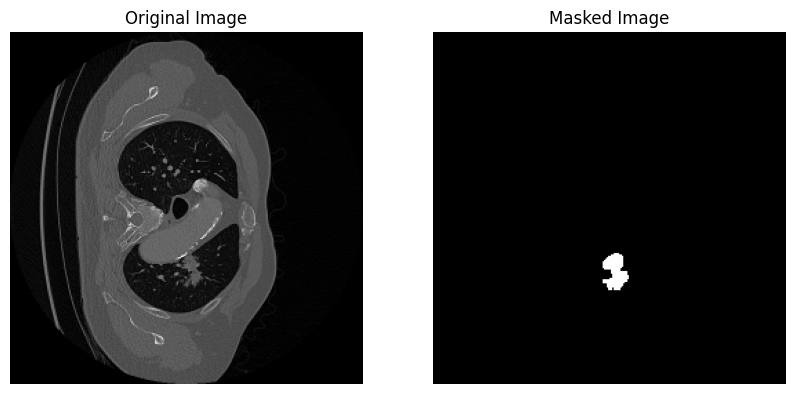

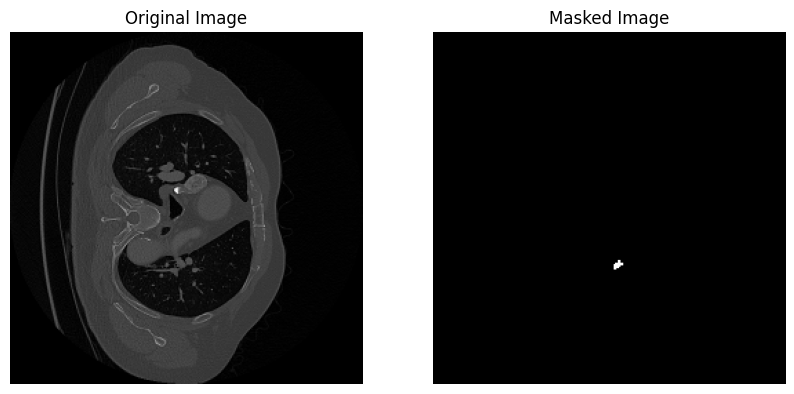

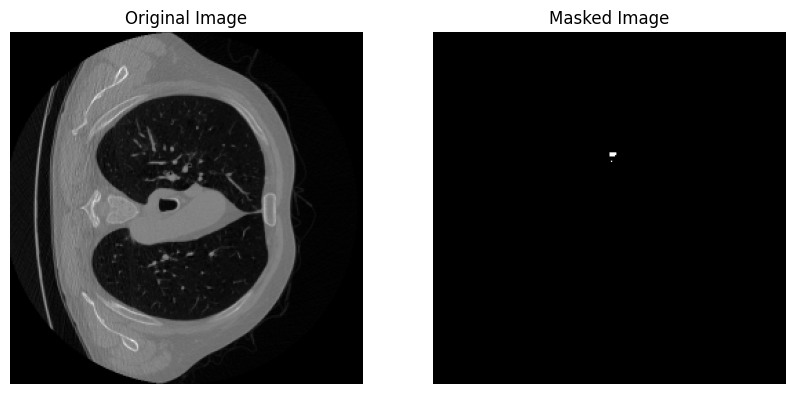

In [4]:
import matplotlib.pyplot as plt
import random

# Random number of images to display
num_to_plot = 5

# Randomly choose indices
random_indices = random.sample(range(len(original_images)), num_to_plot)

for i in random_indices:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_images[i], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(masked_images[i], cmap='gray')
    axes[1].set_title('Masked Image')
    axes[1].axis('off')
    
    plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Step 2: Convert to numpy arrays and add channel dimension
print("\nConverting to numpy arrays...")
X = np.array(original_images)
Y = np.array(masked_images)

print(f"X shape before expand_dims: {X.shape}")
print(f"Y shape before expand_dims: {Y.shape}")

X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)

print(f"X shape after expand_dims: {X.shape}")
print(f"Y shape after expand_dims: {Y.shape}")

# Step 3: Split the data
print("\nSplitting data...")
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")


Converting to numpy arrays...
X shape before expand_dims: (45, 256, 256)
Y shape before expand_dims: (45, 256, 256)
X shape after expand_dims: (45, 256, 256, 1)
Y shape after expand_dims: (45, 256, 256, 1)

Splitting data...
X_train shape: (36, 256, 256, 1)
Y_train shape: (36, 256, 256, 1)
X_val shape: (9, 256, 256, 1)
Y_val shape: (9, 256, 256, 1)


In [7]:
import tensorflow as tf

In [17]:
from tensorflow import keras

# Define better loss function using TensorFlow operations
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Building Unet model 

In [18]:
inputs = tf.keras.layers.Input((256, 256, 1))

# Contracting / Down Sampling
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.3)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.4)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Up sampling / Expansive
u6 = tf.keras.layers.UpSampling2D((2,2))(c5)
u6 = tf.keras.layers.Concatenate()([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.UpSampling2D((2,2))(c6)
u7 = tf.keras.layers.Concatenate()([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.UpSampling2D((2,2))(c7)
u8 = tf.keras.layers.Concatenate()([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.UpSampling2D((2,2))(c8)
u9 = tf.keras.layers.Concatenate()([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Final output layer
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient]
)

In [20]:
# Train model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=2
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(2, 256, 256, 1))
  warnings.warn(msg)


16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9289 - dice_coefficient: 0.0029 - loss: 1.2133

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9361 - dice_coefficient: 0.0028 - loss: 1.1957 - val_accuracy: 0.9981 - val_dice_coefficient: 7.6347e-04 - val_loss: 1.0356
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9966 - dice_coefficient: 0.0019 - loss: 1.0362 - val_accuracy: 0.9981 - val_dice_coefficient: 0.0024 - val_loss: 1.1297
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9973 - dice_coefficient: 0.0021 - loss: 1.0258 - val_accuracy: 0.9981 - val_dice_coefficient: 0.0031 - val_loss: 1.1109
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9972 - dice_coefficient: 0.0043 - loss: 1.0193 - val_accuracy: 0.9981 - val_dice_coefficient: 0.0048 - val_loss: 1.1290
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9975 - dice_coefficient: 0.0093 - loss: 1.0092 - val_accuracy: 0.9981 - val_dice_coefficient: 0.0070 - val_loss: 1.1592
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9974 - dic

Generating predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(9, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

VISUALIZATION: Original | Ground Truth | Predicted


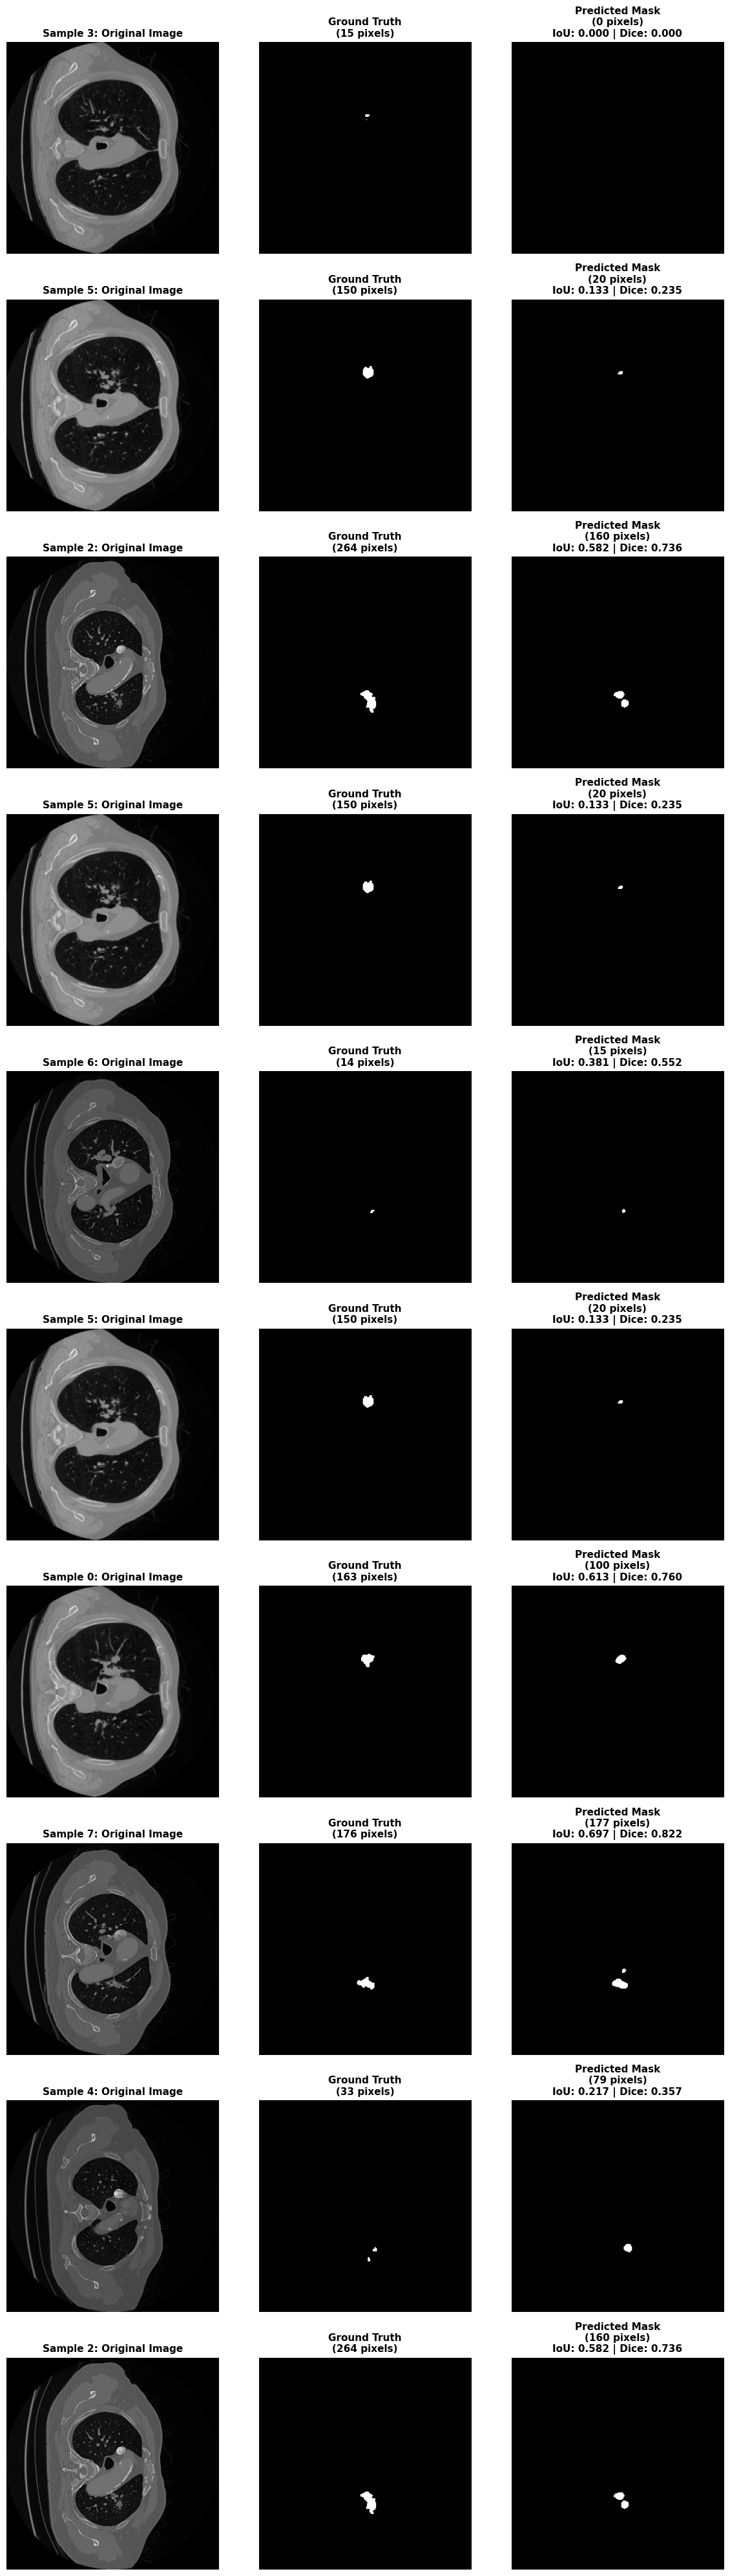


EXTENDED VISUALIZATION with Overlays


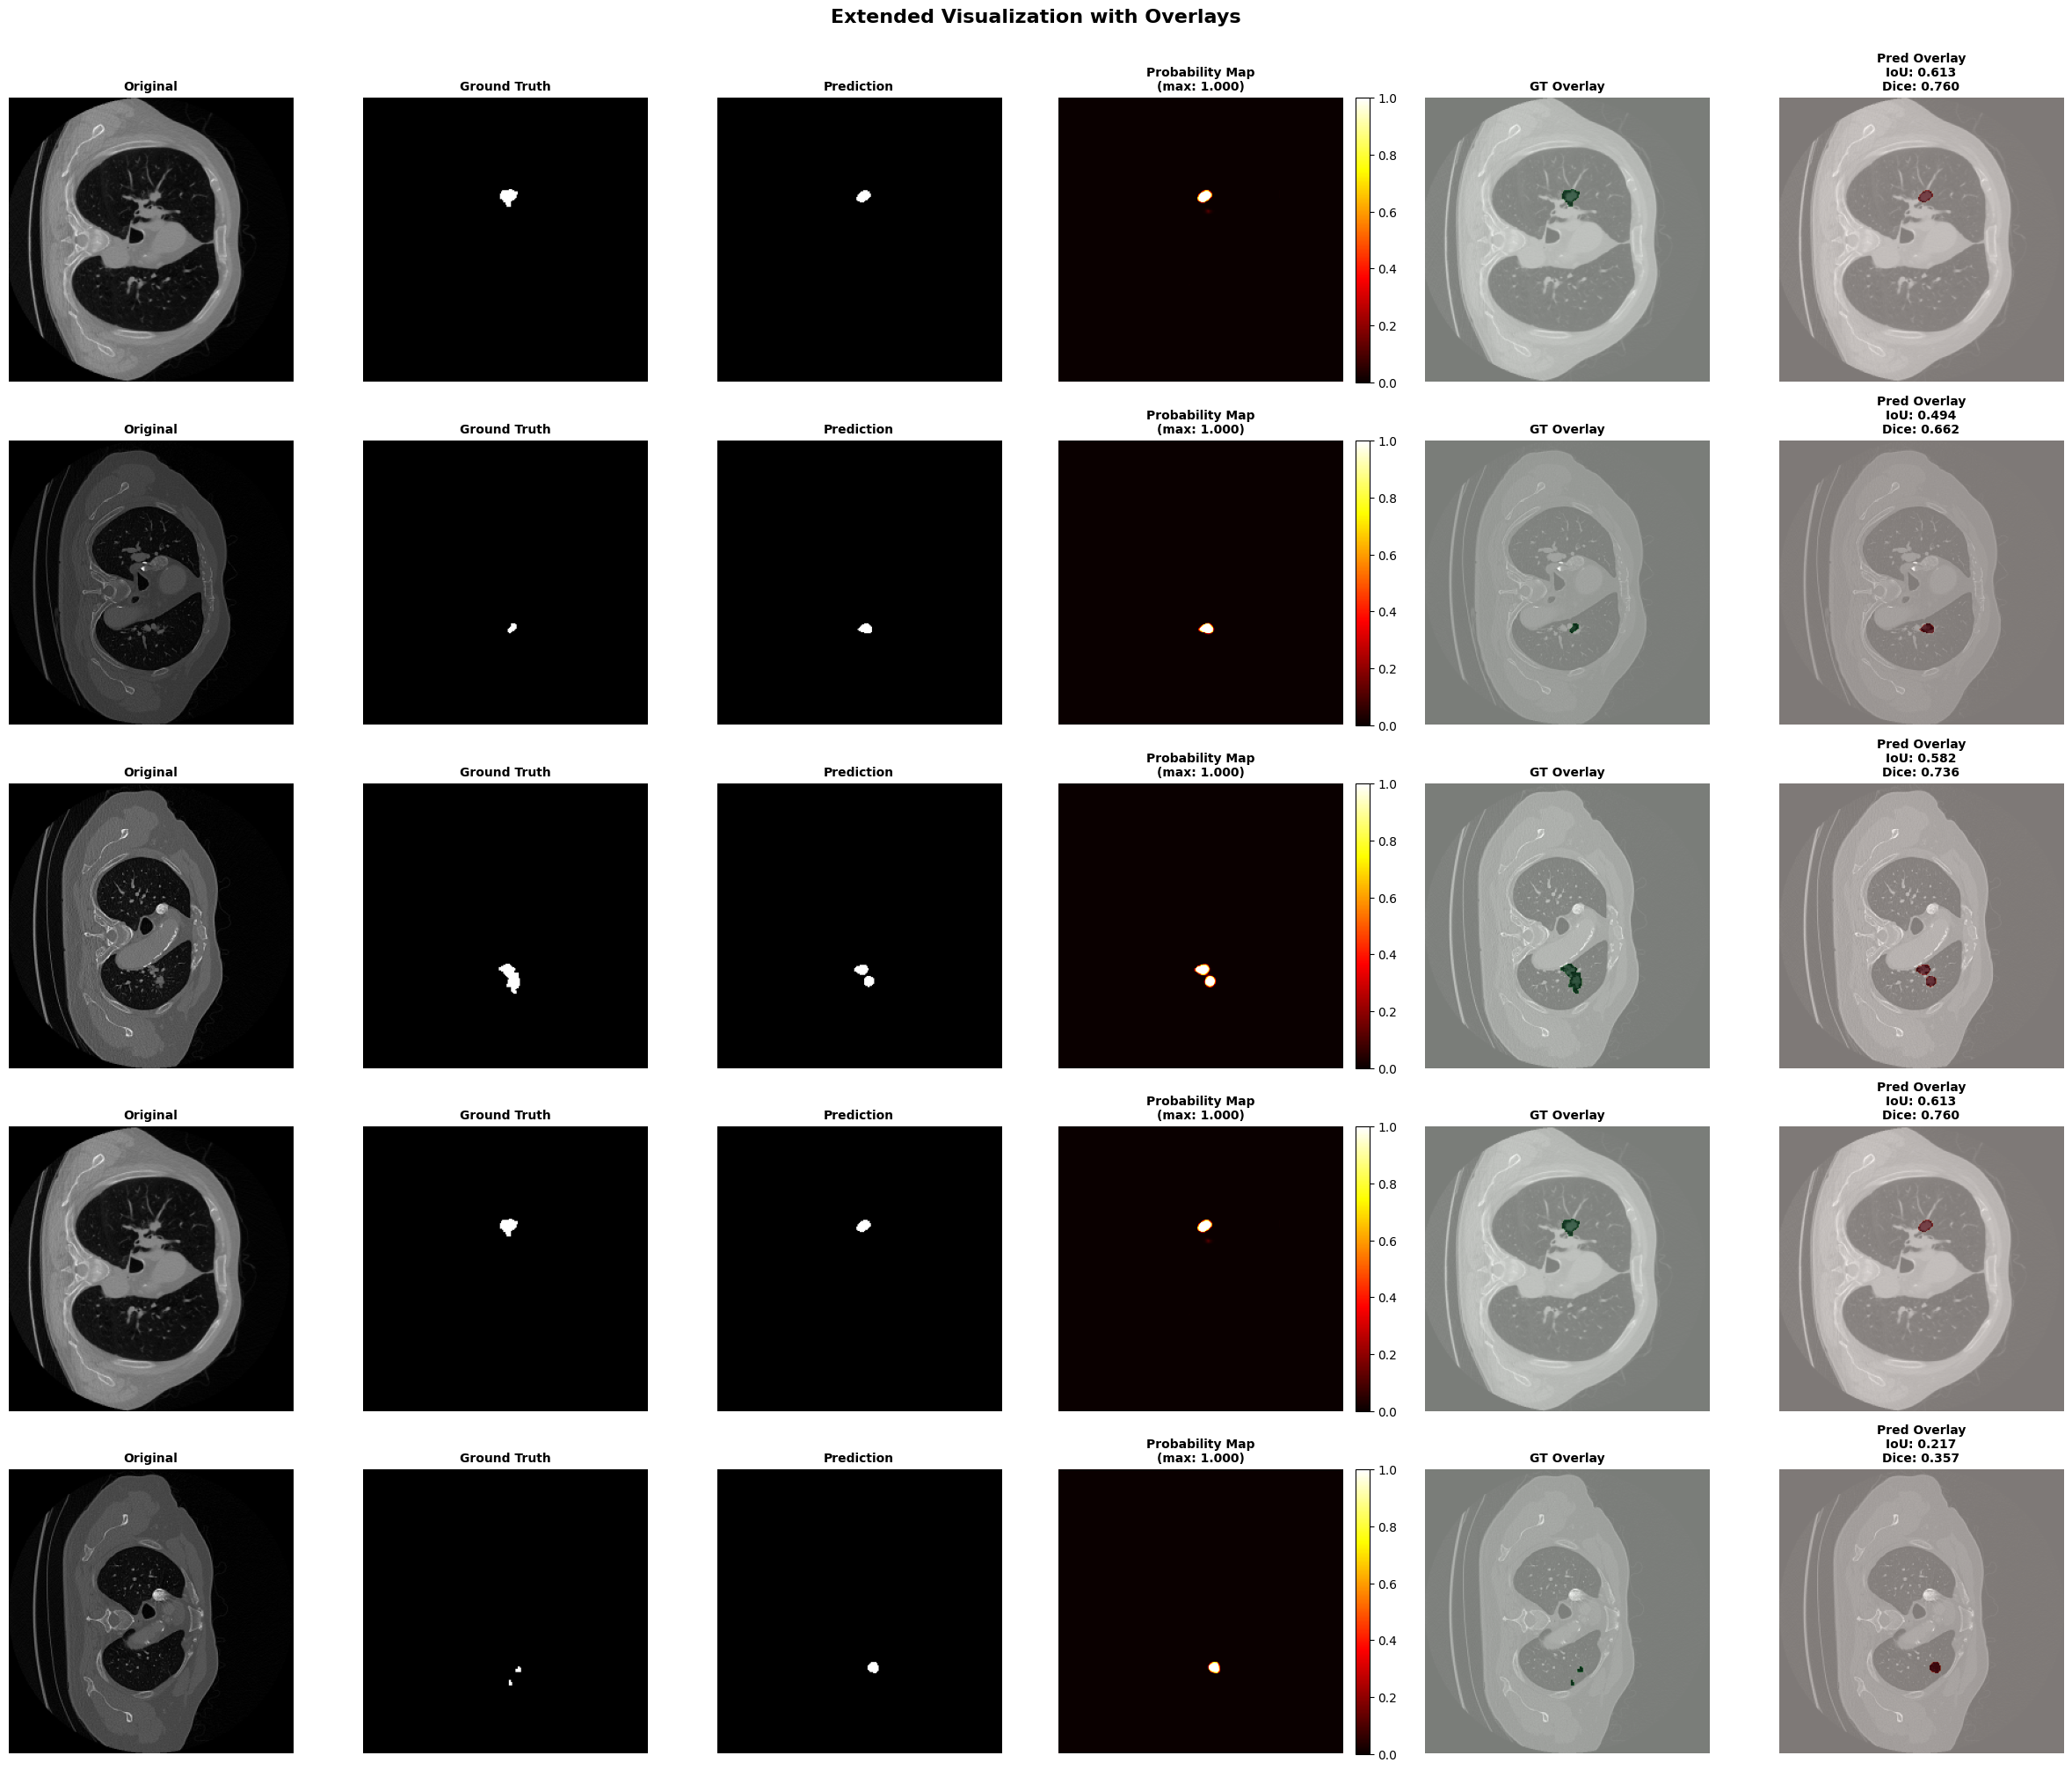


COMPARISON VISUALIZATION


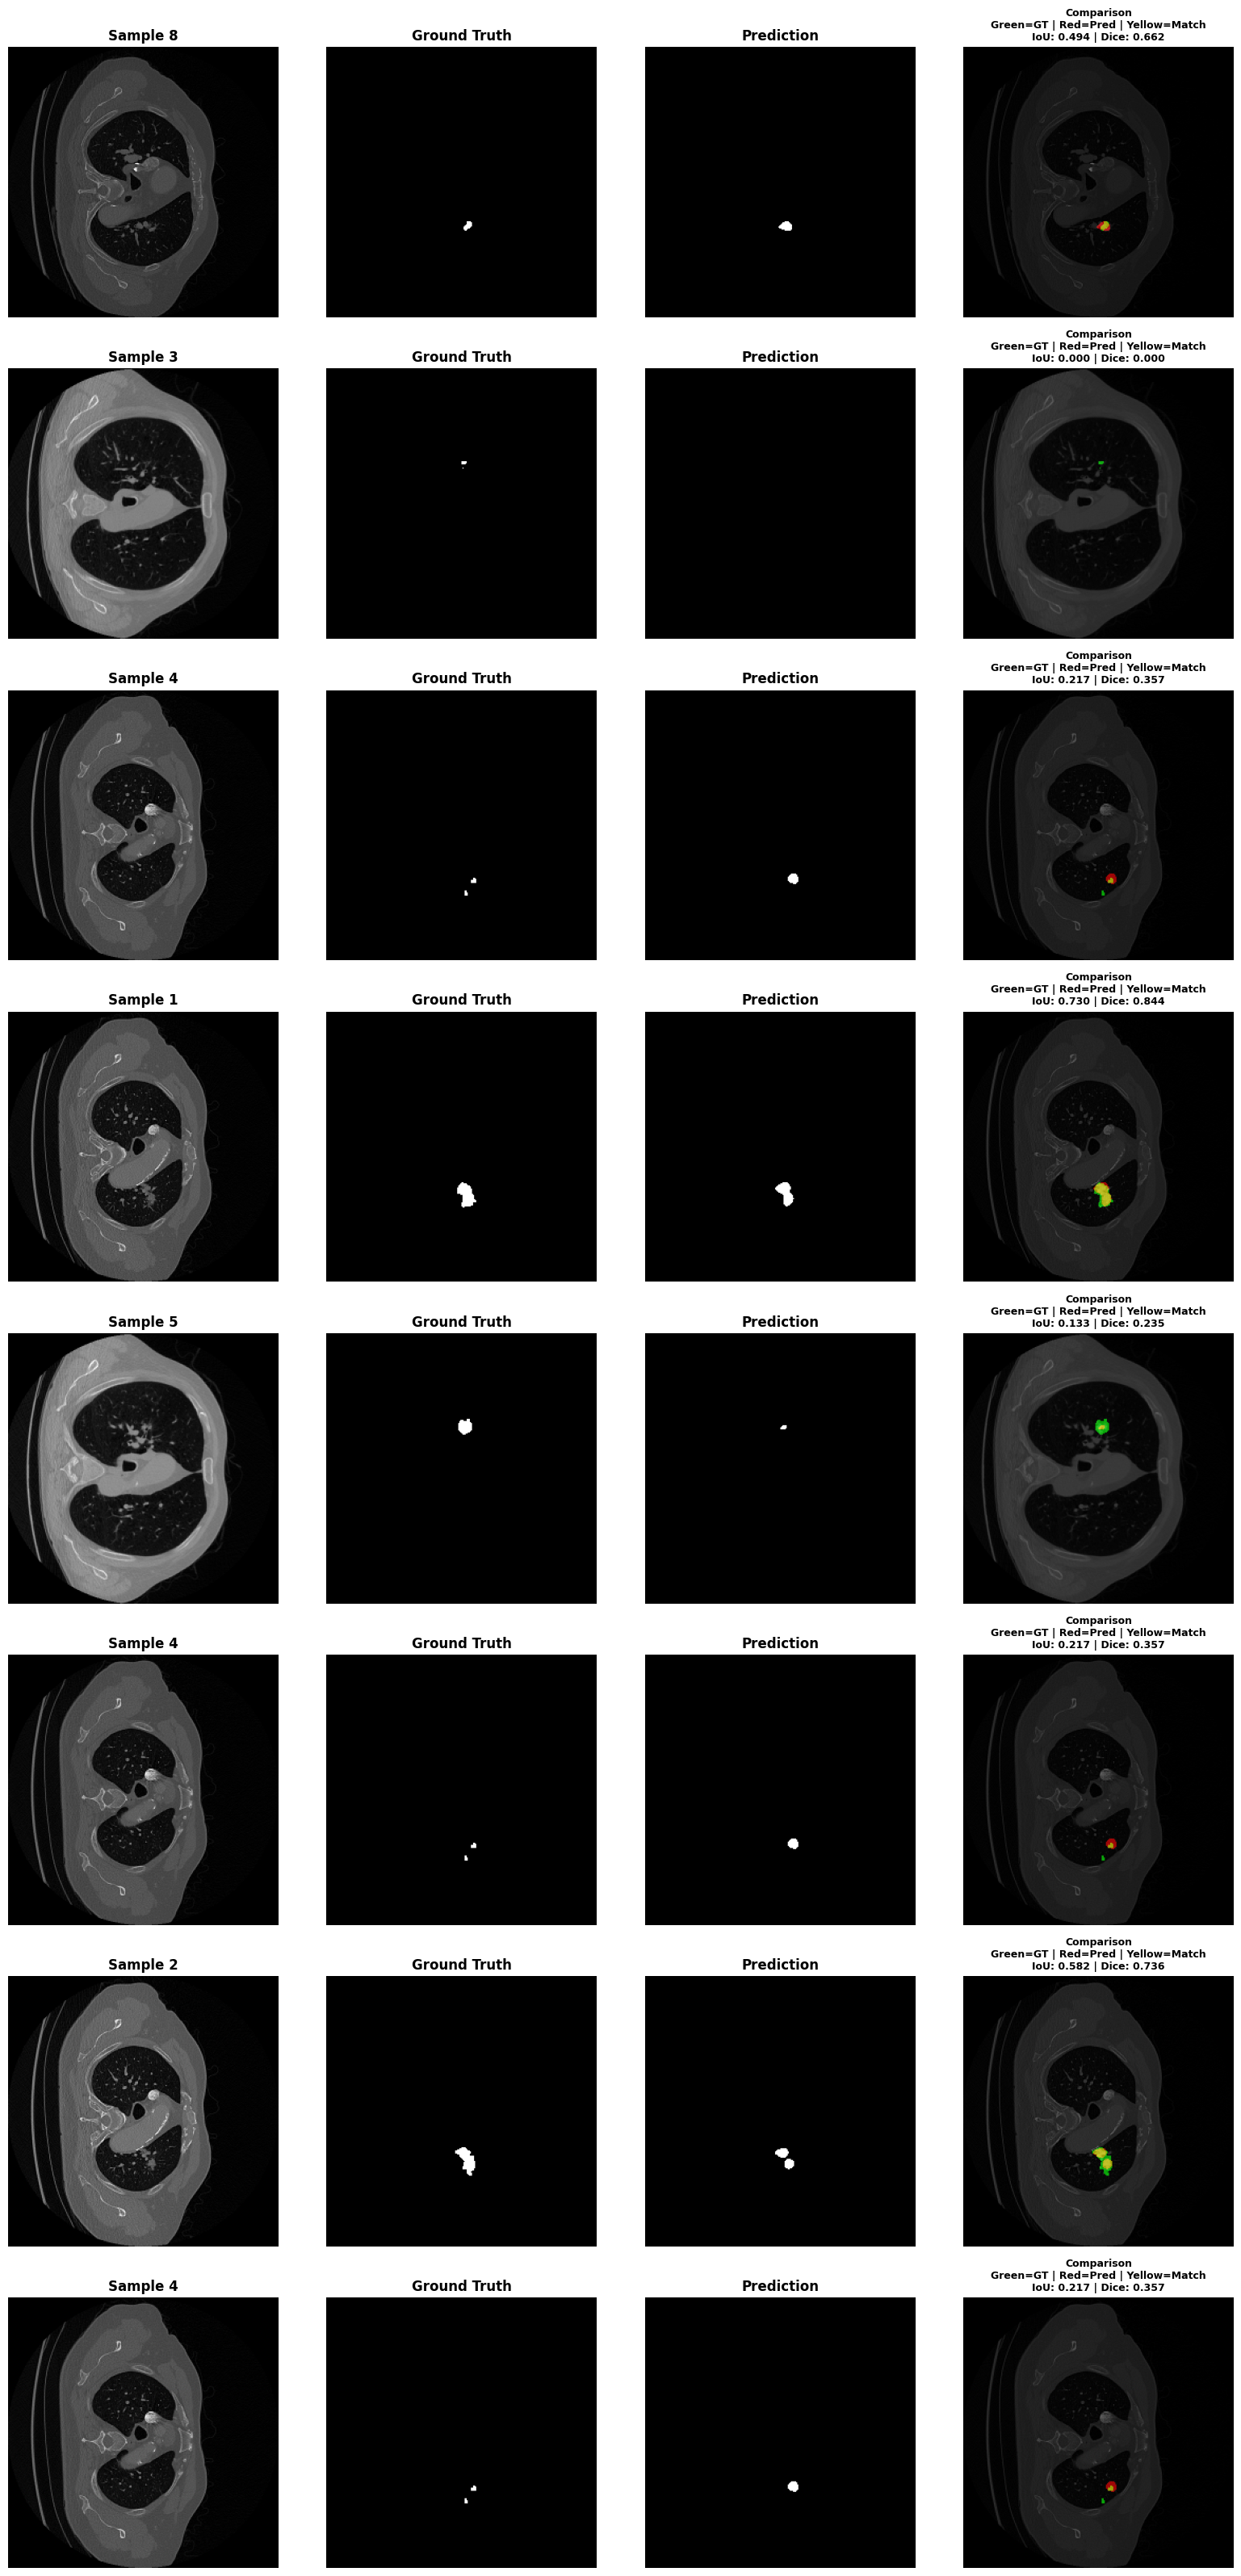


BEST AND WORST PREDICTIONS


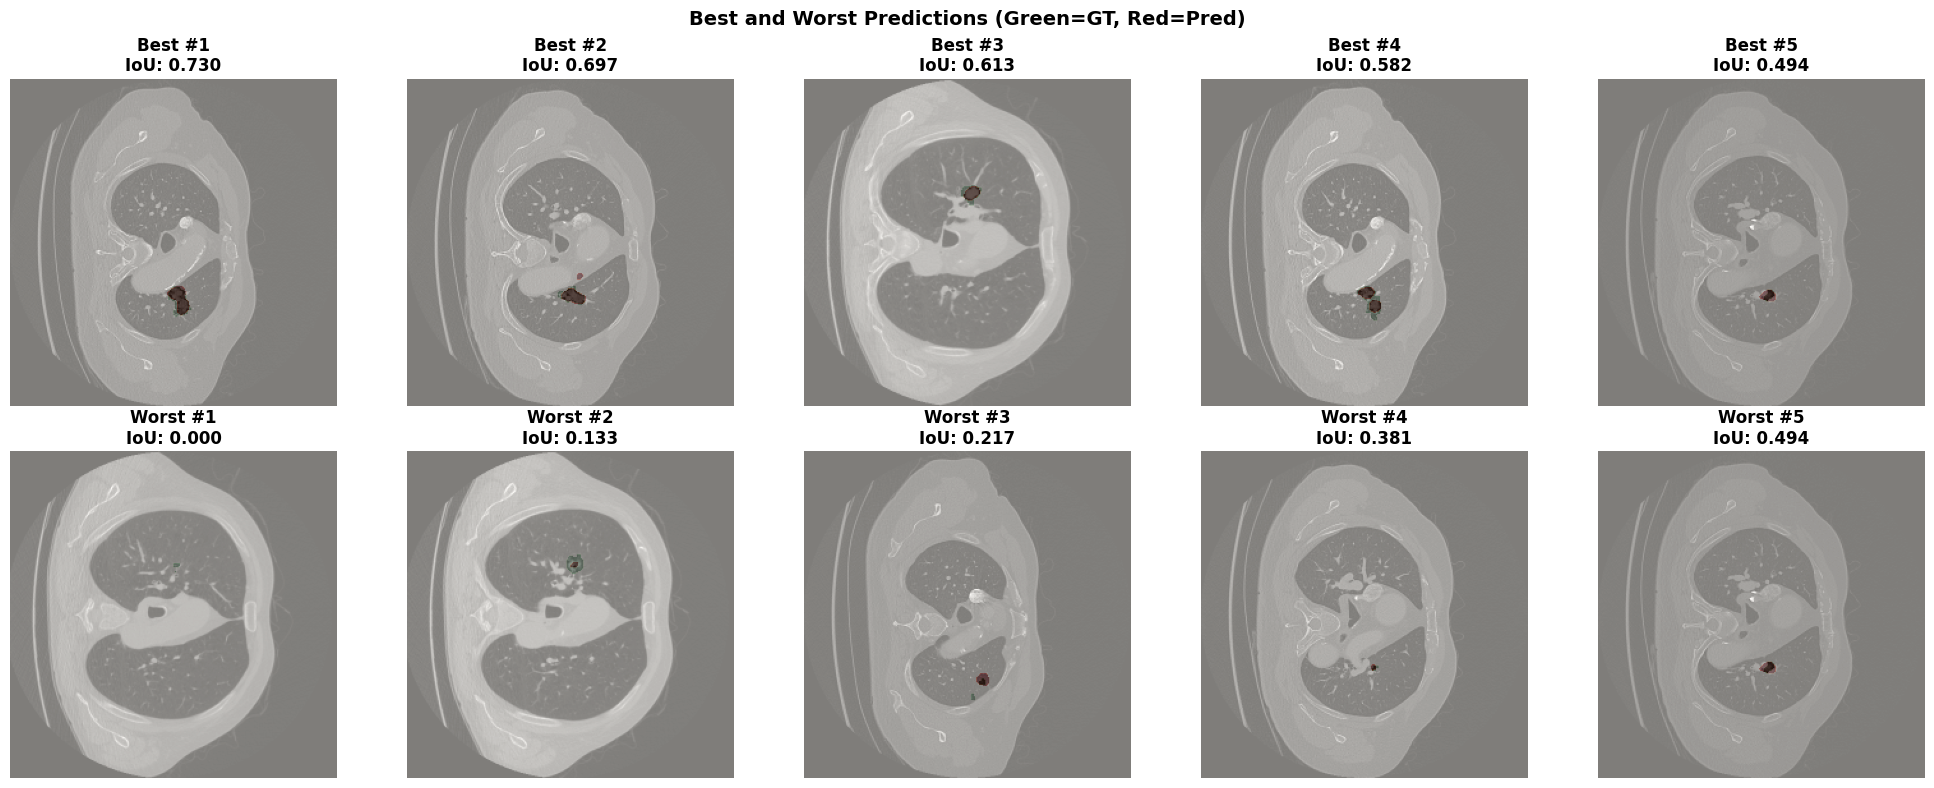


SUMMARY STATISTICS
Mean IoU: 0.4276 ± 0.2456
Median IoU: 0.4943
Best IoU: 0.7302
Worst IoU: 0.0000


In [21]:
# Make predictions on validation set
print("Generating predictions...")
Y_pred = model.predict(X_val, verbose=1)
Y_pred_binary = (Y_pred > 0.5).astype(np.float32)

# Calculate metrics for each sample
def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-7) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

# ============================================
# 1. Simple 3-column visualization
# ============================================
print("\n" + "="*60)
print("VISUALIZATION: Original | Ground Truth | Predicted")
print("="*60)

num_samples = 10
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for idx in range(num_samples):
    i = np.random.randint(0, len(X_val))
    
    # Calculate metrics
    iou = calculate_iou(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    dice = calculate_dice(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    
    # Original Image
    axes[idx, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 0].set_title(f'Sample {i}: Original Image', fontweight='bold', fontsize=11)
    axes[idx, 0].axis('off')
    
    # Ground Truth Mask
    axes[idx, 1].imshow(Y_val[i, :, :, 0], cmap='gray')
    gt_pixels = np.sum(Y_val[i, :, :, 0] > 0.5)
    axes[idx, 1].set_title(f'Ground Truth\n({gt_pixels:.0f} pixels)', fontweight='bold', fontsize=11)
    axes[idx, 1].axis('off')
    
    # Predicted Mask
    axes[idx, 2].imshow(Y_pred_binary[i, :, :, 0], cmap='gray')
    pred_pixels = np.sum(Y_pred_binary[i, :, :, 0] > 0.5)
    axes[idx, 2].set_title(f'Predicted Mask\n({pred_pixels:.0f} pixels)\nIoU: {iou:.3f} | Dice: {dice:.3f}', 
                           fontweight='bold', fontsize=11)
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 2. Extended visualization with overlays
# ============================================
print("\n" + "="*60)
print("EXTENDED VISUALIZATION with Overlays")
print("="*60)

num_samples = 5
fig, axes = plt.subplots(num_samples, 6, figsize=(24, 4*num_samples))

for idx in range(num_samples):
    i = np.random.randint(0, len(X_val))
    
    # Calculate metrics
    iou = calculate_iou(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    dice = calculate_dice(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    
    # 1. Original Image
    axes[idx, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 0].set_title('Original', fontweight='bold', fontsize=10)
    axes[idx, 0].axis('off')
    
    # 2. Ground Truth Mask
    axes[idx, 1].imshow(Y_val[i, :, :, 0], cmap='gray')
    axes[idx, 1].set_title('Ground Truth', fontweight='bold', fontsize=10)
    axes[idx, 1].axis('off')
    
    # 3. Predicted Mask (Binary)
    axes[idx, 2].imshow(Y_pred_binary[i, :, :, 0], cmap='gray')
    axes[idx, 2].set_title('Prediction', fontweight='bold', fontsize=10)
    axes[idx, 2].axis('off')
    
    # 4. Prediction Heatmap (Raw probabilities)
    im = axes[idx, 3].imshow(Y_pred[i, :, :, 0], cmap='hot', vmin=0, vmax=1)
    axes[idx, 3].set_title(f'Probability Map\n(max: {Y_pred[i].max():.3f})', fontweight='bold', fontsize=10)
    axes[idx, 3].axis('off')
    plt.colorbar(im, ax=axes[idx, 3], fraction=0.046, pad=0.04)
    
    # 5. Ground Truth Overlay
    axes[idx, 4].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 4].imshow(Y_val[i, :, :, 0], cmap='Greens', alpha=0.5)
    axes[idx, 4].set_title('GT Overlay', fontweight='bold', fontsize=10)
    axes[idx, 4].axis('off')
    
    # 6. Prediction Overlay
    axes[idx, 5].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 5].imshow(Y_pred_binary[i, :, :, 0], cmap='Reds', alpha=0.5)
    axes[idx, 5].set_title(f'Pred Overlay\nIoU: {iou:.3f}\nDice: {dice:.3f}', 
                           fontweight='bold', fontsize=10)
    axes[idx, 5].axis('off')

plt.suptitle('Extended Visualization with Overlays', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# ============================================
# 3. Comparison visualization (Green=GT, Red=Pred, Yellow=Match)
# ============================================
print("\n" + "="*60)
print("COMPARISON VISUALIZATION")
print("="*60)

num_samples = 8
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

for idx in range(num_samples):
    i = np.random.randint(0, len(X_val))
    
    # Calculate metrics
    iou = calculate_iou(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    dice = calculate_dice(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    
    # Original
    axes[idx, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 0].set_title(f'Sample {i}', fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Ground Truth
    axes[idx, 1].imshow(Y_val[i, :, :, 0], cmap='gray')
    axes[idx, 1].set_title('Ground Truth', fontweight='bold')
    axes[idx, 1].axis('off')
    
    # Prediction
    axes[idx, 2].imshow(Y_pred_binary[i, :, :, 0], cmap='gray')
    axes[idx, 2].set_title('Prediction', fontweight='bold')
    axes[idx, 2].axis('off')
    
    # Comparison (Green=GT only, Red=Pred only, Yellow=Both match)
    axes[idx, 3].imshow(X_val[i, :, :, 0], cmap='gray')
    
    # Create RGB overlay
    overlay = np.zeros((*Y_val[i, :, :, 0].shape, 3))
    gt_mask = Y_val[i, :, :, 0] > 0.5
    pred_mask = Y_pred_binary[i, :, :, 0] > 0.5
    
    # Green for GT only
    overlay[gt_mask & ~pred_mask] = [0, 1, 0]
    # Red for Pred only
    overlay[~gt_mask & pred_mask] = [1, 0, 0]
    # Yellow for both (correct prediction)
    overlay[gt_mask & pred_mask] = [1, 1, 0]
    
    axes[idx, 3].imshow(overlay, alpha=0.6)
    axes[idx, 3].set_title(f'Comparison\nGreen=GT | Red=Pred | Yellow=Match\nIoU: {iou:.3f} | Dice: {dice:.3f}', 
                           fontsize=9, fontweight='bold')
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 4. Best and Worst predictions
# ============================================
print("\n" + "="*60)
print("BEST AND WORST PREDICTIONS")
print("="*60)

# Calculate IoU for all samples
iou_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i, :, :, 0], Y_pred_binary[i, :, :, 0])
    iou_scores.append(iou)

# Get best and worst indices
best_indices = np.argsort(iou_scores)[-5:][::-1]
worst_indices = np.argsort(iou_scores)[:5]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Best predictions
for idx, i in enumerate(best_indices):
    axes[0, idx].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[0, idx].imshow(Y_val[i, :, :, 0], cmap='Greens', alpha=0.3)
    axes[0, idx].imshow(Y_pred_binary[i, :, :, 0], cmap='Reds', alpha=0.3)
    axes[0, idx].set_title(f'Best #{idx+1}\nIoU: {iou_scores[i]:.3f}', fontweight='bold')
    axes[0, idx].axis('off')

# Worst predictions
for idx, i in enumerate(worst_indices):
    axes[1, idx].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[1, idx].imshow(Y_val[i, :, :, 0], cmap='Greens', alpha=0.3)
    axes[1, idx].imshow(Y_pred_binary[i, :, :, 0], cmap='Reds', alpha=0.3)
    axes[1, idx].set_title(f'Worst #{idx+1}\nIoU: {iou_scores[i]:.3f}', fontweight='bold')
    axes[1, idx].axis('off')

plt.suptitle('Best and Worst Predictions (Green=GT, Red=Pred)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Mean IoU: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
print(f"Median IoU: {np.median(iou_scores):.4f}")
print(f"Best IoU: {np.max(iou_scores):.4f}")
print(f"Worst IoU: {np.min(iou_scores):.4f}")